# 1. Imports

In [24]:
# scikit-learn
from sklearn import set_config # return pd.DataFrame from transformers
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# others
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import numpy as np
import pickle # move transformers and estimators between notebooks

# custom helper functions
from helper_functions import plot_decision_tree, generate_anomalies, explain_prediction_dt, explain_prediction_iso

<hr>

# 2. Settings

In [25]:
# set sklearn functions to output pd.DataFrames
set_config(transform_output='pandas')

# plot figures with higher resolutions
plt.rcParams['figure.dpi'] = 150

<hr>

# 3.Preprocessing

## 3.1 General Preprocessing

In [26]:
# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index

In [27]:
# TODO: Decide, whether to drop Sex or not

# drop the index and the nominal feature 'sex'
df.drop(columns=['Sex'], inplace=True)

In [28]:
df

,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...
611,3=Cirrhosis,62,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
612,3=Cirrhosis,64,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
613,3=Cirrhosis,64,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
614,3=Cirrhosis,46,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


In [29]:
# seperate features and label
X = df.drop(columns='Category')
y = df['Category']

In [30]:
# numerically encode labels whilst storing their names
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [31]:
# extract class names from label encoder
class_names = label_encoder.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

class_names

['Blood Donor', 'suspect Blood Donor', 'Hepatitis', 'Fibrosis', 'Cirrhosis']

In [32]:
# create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=42)

## 3.2 Missing Data

### 3.2.1 Inspection

In [33]:
# calculate the # of missing values per feature
X_missing = X.isnull().sum()

print("Missing Values per Feature:\n")
print(X_missing)

Missing Values per Feature:

Age      0
ALB      1
ALP     18
ALT      1
AST      0
BIL      0
CHE      0
CHOL    10
CREA     0
GGT      0
PROT     1
dtype: int64


### 3.2.2 Imputation

In [34]:
imputer = KNNImputer(n_neighbors=5, weights='distance') # initialize the imputer

## 3.3 Pipeline

In [35]:
# combine all transformers from preprocessing to pipeline
preprocessing = Pipeline(steps=[('imputation', imputer)])

<hr>

# 4.  Decision Tree Classifier

## 4.1 Training

In [36]:
# initialize the decision tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

In [37]:
# encapsulate the decision tree in a pipeline
decision_tree = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('tree', clf)
    ])

In [38]:
# train the decision tree
#decision_tree.fit(X_train.values, y_train)
decision_tree.fit(X_train.values, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputation',
                                  KNNImputer(weights='distance'))])),
                ('tree', DecisionTreeClassifier(max_depth=5, random_state=42))])

## 4.2 Evaluation

In [39]:
# predict classes from the test set
y_pred = decision_tree.predict(X_test.values)

In [40]:
# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

In [41]:
# print summary
print(f'Using a depth of {clf.get_depth()}, the tree achieves {round(np.multiply(accuracy, 100), 2)} % accuracy ')

Using a depth of 5, the tree achieves 88.21 % accuracy 


## 4.3 Visualization

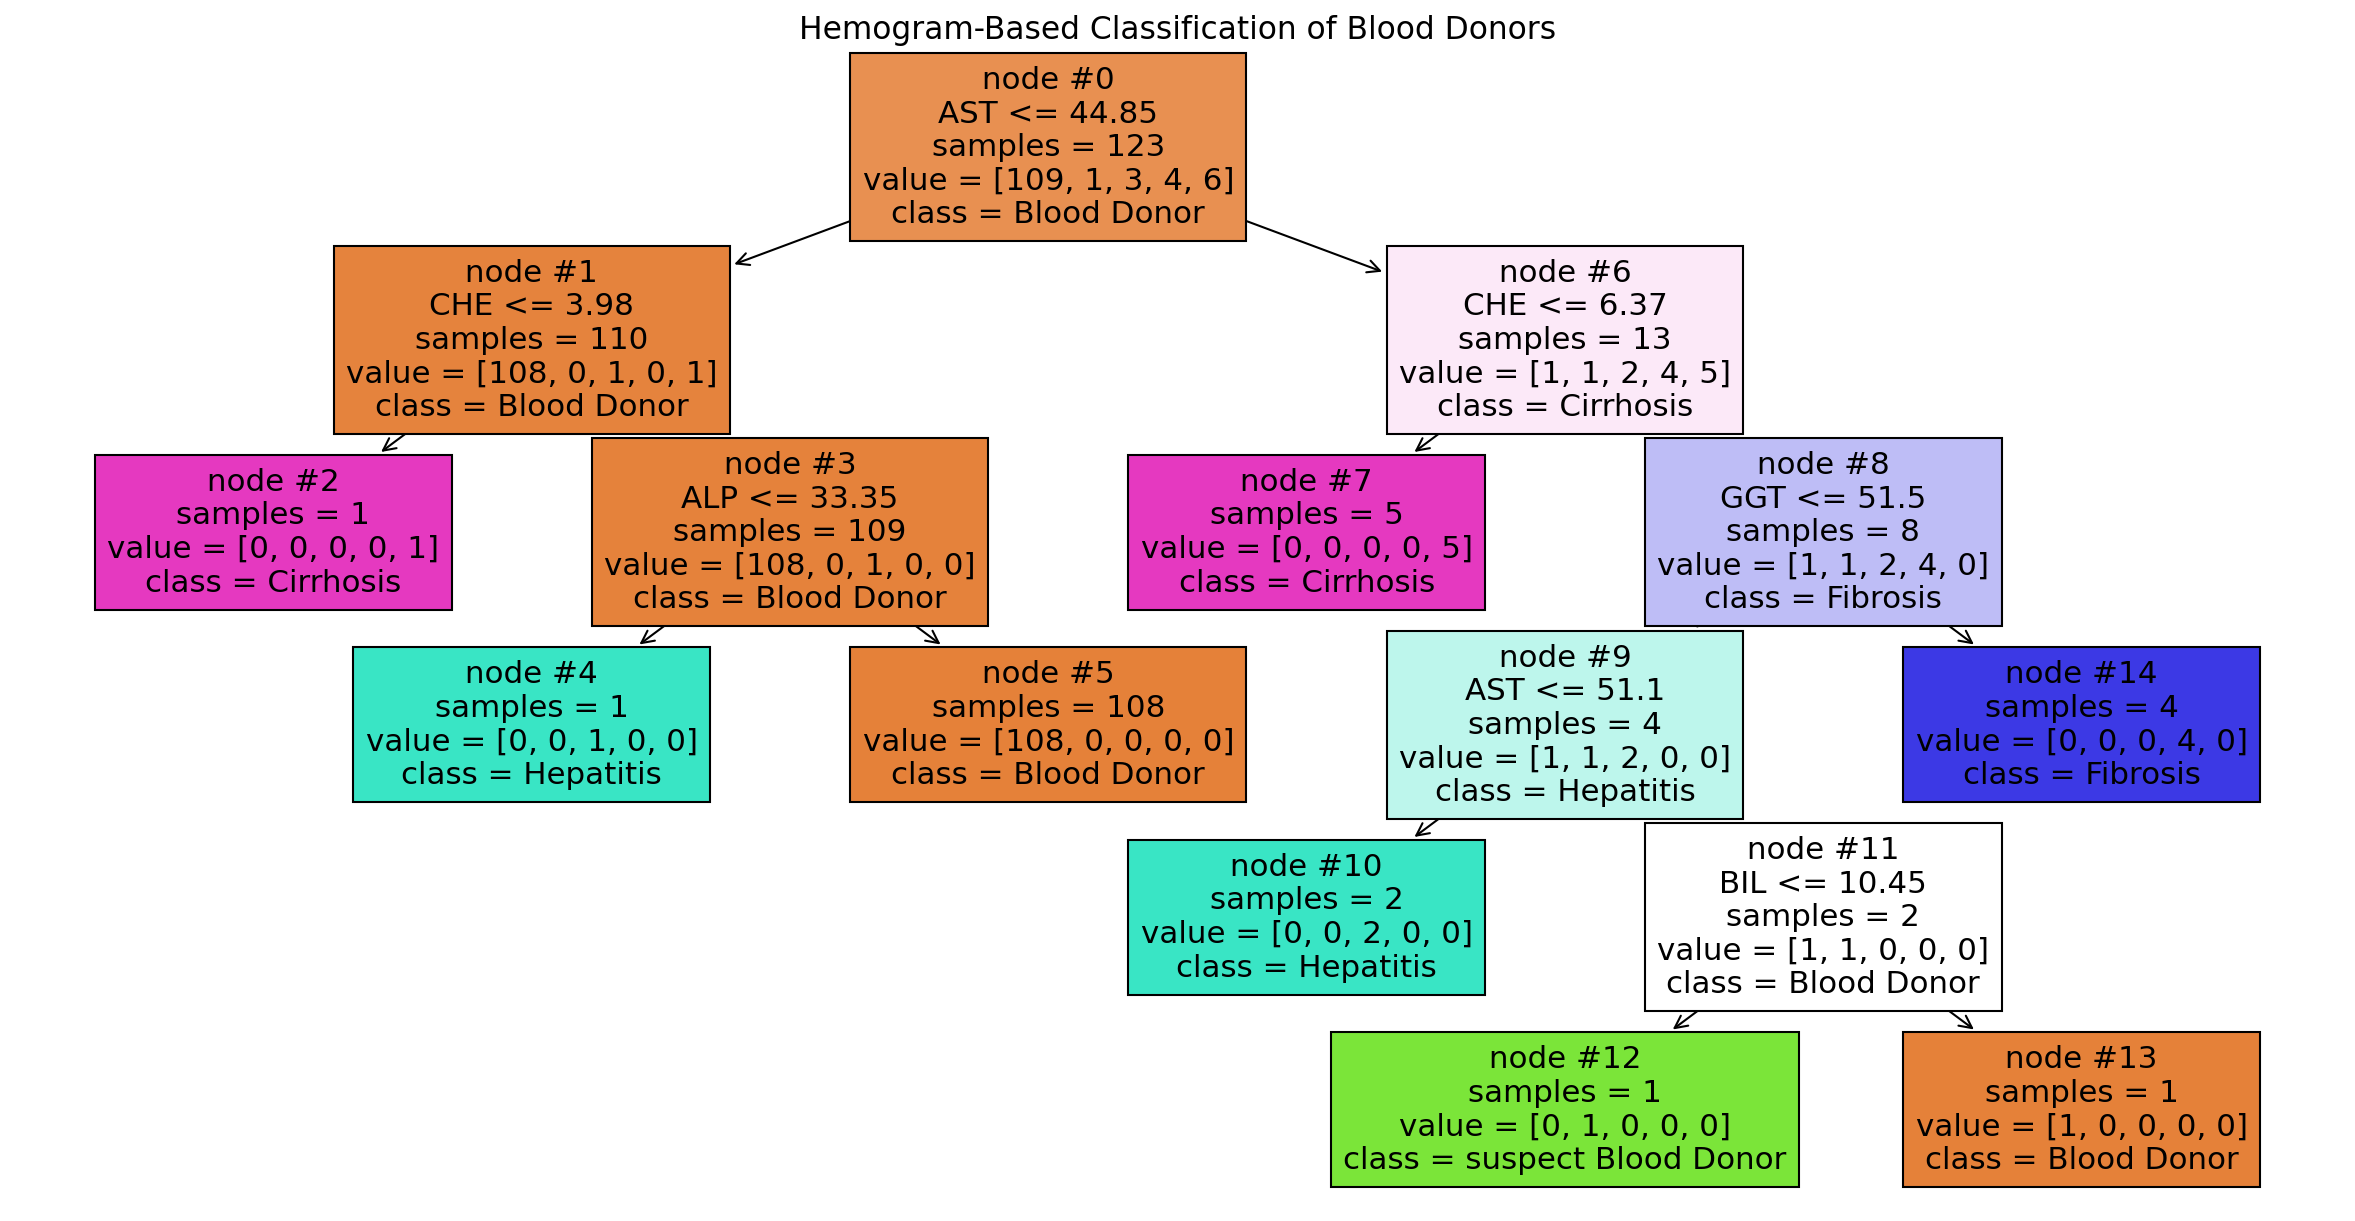

In [42]:
plot_decision_tree(decision_tree=clf, feature_names=list(X.columns), class_names=class_names)

# FRAGE: Brauchen wir hier auch einen Decison Tree 4.4 Decision Path

# 5. Pipeline

# Note that warnings are thrown, because our function predicts each patient, so one row at a time, which results in X having no feature name. Due to the fact that we generate a few samples we can garantie the right oder of the features put into our pipeline 

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
import pandas as pd 
import warnings

# read the data
df = pd.read_csv('./data/hcvdat33_Complete.csv', index_col=0) # use first col as index

label_encoder_sex = LabelEncoder()
df['Sex'] = label_encoder_sex.fit_transform(df['Sex'])

X = df.drop(columns=["Category"])
column_order = [col for col in X.columns if col != 'Sex'] + ['Sex']
X = X[column_order]

y = df["Category"]

y_copy = y.copy()

label_encoder_names = LabelEncoder() 
y = label_encoder_names.fit_transform(y)
class_names = label_encoder_names.classes_
class_names = [class_name.split('=')[1] for class_name in class_names]
class_names = list(map(str, class_names)) # convert to list of strings

numerical_columns = ["Age","ALB","ALP","ALT","AST","BIL","CHE","CHOL","CREA","GGT","PROT"]

knn = KNeighborsRegressor(n_neighbors=5)
iterative_imputer = IterativeImputer(estimator=knn, add_indicator=False)
imputer = ColumnTransformer([("imputer", iterative_imputer, numerical_columns)],
                            remainder="passthrough",
                            verbose_feature_names_out=False).set_output(transform="pandas")

#sample = X.iloc[[3,50,600], :]

class Combiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dt = DecisionTreeClassifier()
        self.iso = IsolationForest()
        self.rs = RobustScaler()
        self.pca = PCA(n_components=2)

    def scale_pca_fit_transform (self,X):
        rs_data= self.rs.fit_transform(X)
        pca_data= self.pca.fit_transform(rs_data)
        return pca_data

    def  scale_pca_transform  (self, X):
        rs_data= self.rs.transform(X)
        pca_data= self.pca.transform(rs_data)
        return pca_data

    def fit(self, X, y=None):
        self.dt.fit(X, y)
        # Get only data from Blood donors
        index_blood_donor = y_copy[y_copy=="0=Blood Donor"].index
        blood_donor=X.iloc[index_blood_donor,:]

        prepedData= self.scale_pca_fit_transform(blood_donor)
        self.iso.fit(prepedData)

    def transform(self, sample):
        prepedData = self.scale_pca_transform(sample)

        plot_decision_tree(self.dt, feature_names=list(sample.columns), class_names=class_names)

        for index in sample.index:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                print("Predicted output for Patient with index:", index)
                row_dt = sample.loc[index,:]
                sample_2d_dt = row_dt.values.reshape(1,-1)
                explain_prediction_dt(self.dt, sample_2d_dt, class_names)
                
                row_iso = prepedData.loc[index,:]
                sample_2d_iso = row_iso.values.reshape(1,-1)
                explain_prediction_iso(self.iso, sample_2d_iso)
            

pipeline = Pipeline([("imputer", imputer),
                    ('combiner', Combiner())
                    ])

pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  IterativeImputer(estimator=KNeighborsRegressor()),
                                                  ['Age', 'ALB', 'ALP', 'ALT',
                                                   'AST', 'BIL', 'CHE', 'CHOL',
                                                   'CREA', 'GGT', 'PROT'])],
                                   verbose_feature_names_out=False)),
                ('combiner', Combiner())])

## 6. Test the generated samples

In [44]:
anomalies =generate_anomalies(30)

In [45]:
anomalies

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,16,f,28,141,97,255,23,24,10,15,126,30
1,65,m,10,38,84,270,23,9,3,52,114,83
2,22,f,28,116,41,92,9,10,3,13,11,12
3,37,f,73,96,112,331,39,19,12,27,65,24
4,65,m,72,77,102,277,34,20,10,64,214,66
5,26,m,34,197,158,317,16,21,12,31,210,48
6,37,f,78,166,126,208,14,8,8,63,30,67
7,36,f,30,94,110,90,31,4,6,51,293,86
8,26,m,47,27,70,145,9,20,2,37,216,4
9,69,f,13,97,122,294,38,9,6,29,236,48


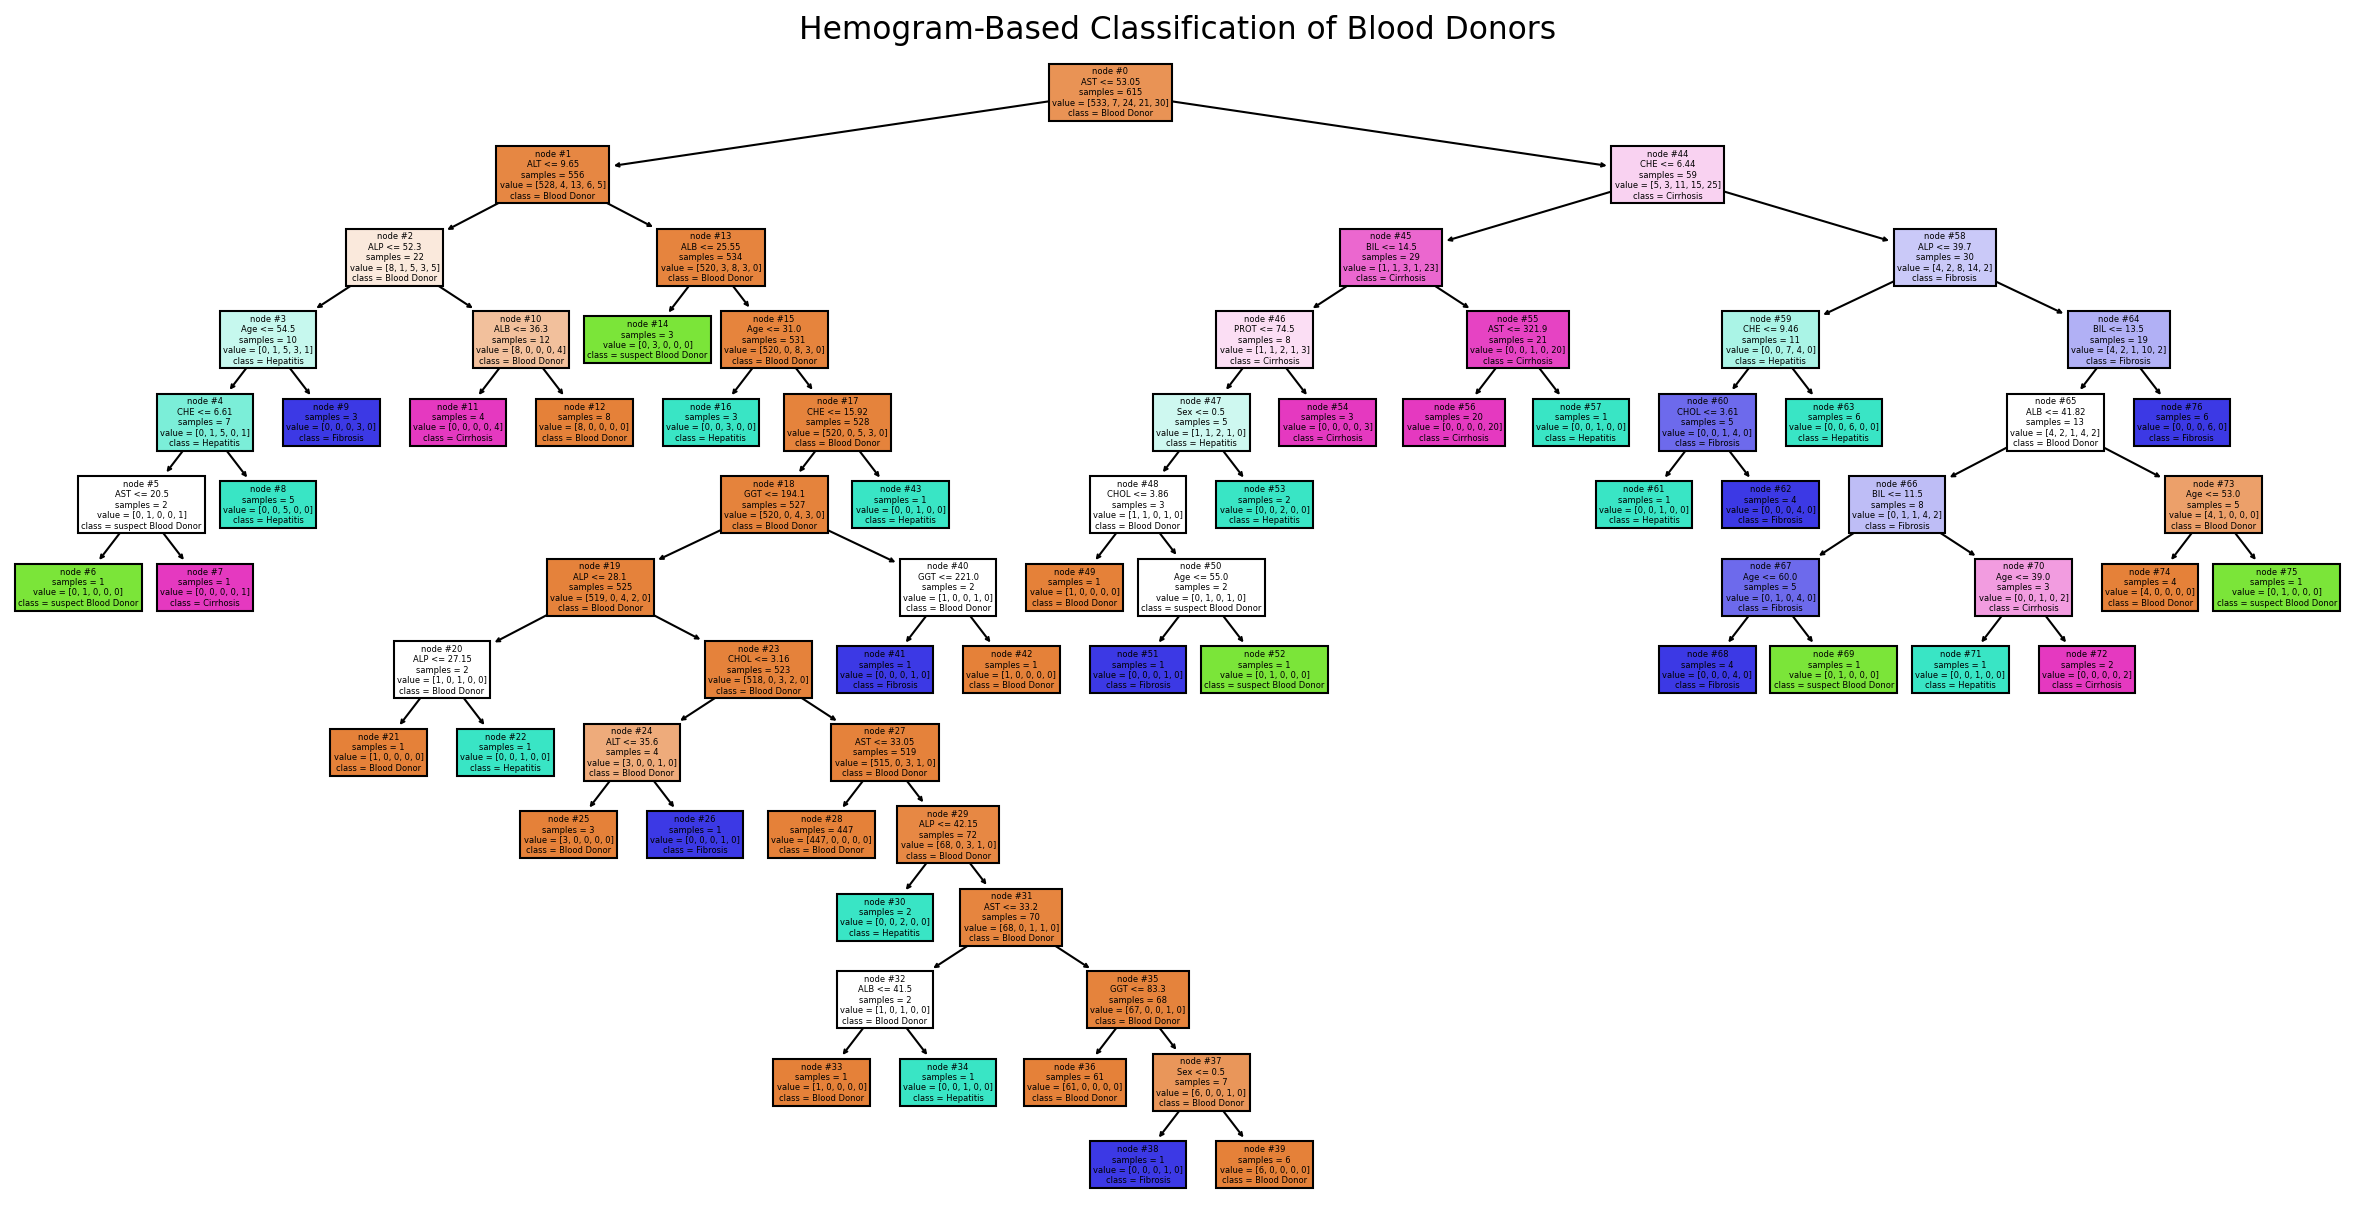

Predicted output for Patient with index: 0
Predicted Class: Fibrosis
Path taken: Nodes 0, 44, 58, 64 and 76
This patient shows an anomaly
This is the value calulated [-0.31740326] 

Predicted output for Patient with index: 1
Predicted Class: Hepatitis
Path taken: Nodes 0, 44, 58, 59, 60 and 61
This patient shows an anomaly
This is the value calulated [-0.31464271] 

Predicted output for Patient with index: 2
Predicted Class: Fibrosis
Path taken: Nodes 0, 44, 58, 64, 65, 66, 67 and 68
This patient shows no anomaly
This is the value calulated [0.07548278] 

Predicted output for Patient with index: 3
Predicted Class: Fibrosis
Path taken: Nodes 0, 44, 58, 64 and 76
This patient shows an anomaly
This is the value calulated [-0.31795649] 

Predicted output for Patient with index: 4
Predicted Class: Fibrosis
Path taken: Nodes 0, 44, 58, 64 and 76
This patient shows an anomaly
This is the value calulated [-0.3240668] 

Predicted output for Patient with index: 5
Predicted Class: Fibrosis
Path t

In [46]:
label_encoder_sex = LabelEncoder()
anomalies['Sex'] = label_encoder_sex.fit_transform(anomalies['Sex'])
  
pipeline.fit(X,y)
pipeline.transform(anomalies) #TODO Self gen data

# 6.2 Discussion